# Preparations

## Importing required packages

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar

## Loading the data

In [322]:
df = pd.read_csv("JAPAN_EMSC.csv")

## Making index to start from No.1

In [323]:
df = df.reset_index(drop=True)
df.index = range(1, len(df)+1)

## Shape

In [324]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

There are 118 rows and 7 columns


## Type of data 

In [325]:
df.dtypes

date_time_UTC       object
latitude_deg       float64
longitude_deg      float64
depth_km             int64
magnitude_value    float64
magnitude_type      object
region              object
dtype: object

## Converting data type of numerical columns to float 

In [326]:
df["depth_km"] = df["depth_km"].astype("float")

## Converting data type of date_time column to datetime

In [327]:
df["date_time_UTC"] = pd.to_datetime(df["date_time_UTC"], format="%Y-%m-%d %H:%M:%S")

In [328]:
df.dtypes

date_time_UTC      datetime64[ns]
latitude_deg              float64
longitude_deg             float64
depth_km                  float64
magnitude_value           float64
magnitude_type             object
region                     object
dtype: object

## Spotting NaN

In [329]:
df.isna().sum()

date_time_UTC      0
latitude_deg       0
longitude_deg      0
depth_km           0
magnitude_value    0
magnitude_type     0
region             0
dtype: int64

## Spotting & Removing events happened outside Japan 

### Spotting events happened outside Japan

In [330]:
# print(df)
def spot_loation(value):
    if not "JAPAN" in value:
        value = "outside Japan"
    return value

df["region"] = df["region"].apply(spot_loation)

not_japan = (df["region"]=="outside Japan").sum()
print(f"Out of {df.shape[0]} records, {not_japan} of them aren't related to Japan")   

Out of 118 records, 8 of them aren't related to Japan


In [331]:
x = df[df["region"]=="outside Japan"]
print(x["region"])

12     outside Japan
29     outside Japan
54     outside Japan
59     outside Japan
61     outside Japan
67     outside Japan
115    outside Japan
116    outside Japan
Name: region, dtype: object


### Removing events happened outside Japan

In [332]:
df = df[df["region"]!="outside Japan"]
df.shape
print(df)

          date_time_UTC  latitude_deg  longitude_deg  depth_km  \
1   2025-10-12 03:34:30        42.300        143.000      60.0   
2   2025-10-11 19:25:30        36.900        136.300      10.0   
3   2025-10-11 14:24:30        27.300        127.700      90.0   
4   2025-10-11 03:30:30        36.600        141.000      50.0   
5   2025-10-11 03:22:01        30.369        138.511     437.0   
..                  ...           ...            ...       ...   
112 2025-09-16 01:21:30        35.900        140.800      40.0   
113 2025-09-15 19:00:06        37.619        138.969     180.0   
114 2025-09-15 08:43:30        36.900        141.400      50.0   
117 2025-09-15 04:34:47        38.437        141.987      65.0   
118 2025-09-15 02:32:30        29.400        129.500      10.0   

     magnitude_value magnitude_type                            region  
1                3.6              M            HOKKAIDO, JAPAN REGION  
2                3.6              M  NEAR WEST COAST OF HONSHU,

## Adding a new column: Month

In [333]:
df.insert(1, "Month", value= df["date_time_UTC"].apply(lambda x: calendar.month_name[x.month]))

## Adding a new column: Category

In [334]:
def classify_mag(value):
    if value < 4:
        return "weak"
    elif 4 <= value <= 6:
        return "moderate"
    else:
        return "strong"
        
x = df["magnitude_value"].apply(classify_mag)
df.insert(7, "Category", value = x)

## Changing the name of column 'region' to 'place'

In [335]:
df = df.rename(columns={"region":"place"})

## Defining a new column: Region

In [336]:
print(df)

          date_time_UTC      Month  latitude_deg  longitude_deg  depth_km  \
1   2025-10-12 03:34:30    October        42.300        143.000      60.0   
2   2025-10-11 19:25:30    October        36.900        136.300      10.0   
3   2025-10-11 14:24:30    October        27.300        127.700      90.0   
4   2025-10-11 03:30:30    October        36.600        141.000      50.0   
5   2025-10-11 03:22:01    October        30.369        138.511     437.0   
..                  ...        ...           ...            ...       ...   
112 2025-09-16 01:21:30  September        35.900        140.800      40.0   
113 2025-09-15 19:00:06  September        37.619        138.969     180.0   
114 2025-09-15 08:43:30  September        36.900        141.400      50.0   
117 2025-09-15 04:34:47  September        38.437        141.987      65.0   
118 2025-09-15 02:32:30  September        29.400        129.500      10.0   

     magnitude_value magnitude_type  Category  \
1                3.6      

In [337]:
def f(x):
    x = x.split(",")
    return x[0]

df["region"] = df["place"].apply(f)

In [338]:
print(df)

          date_time_UTC      Month  latitude_deg  longitude_deg  depth_km  \
1   2025-10-12 03:34:30    October        42.300        143.000      60.0   
2   2025-10-11 19:25:30    October        36.900        136.300      10.0   
3   2025-10-11 14:24:30    October        27.300        127.700      90.0   
4   2025-10-11 03:30:30    October        36.600        141.000      50.0   
5   2025-10-11 03:22:01    October        30.369        138.511     437.0   
..                  ...        ...           ...            ...       ...   
112 2025-09-16 01:21:30  September        35.900        140.800      40.0   
113 2025-09-15 19:00:06  September        37.619        138.969     180.0   
114 2025-09-15 08:43:30  September        36.900        141.400      50.0   
117 2025-09-15 04:34:47  September        38.437        141.987      65.0   
118 2025-09-15 02:32:30  September        29.400        129.500      10.0   

     magnitude_value magnitude_type  Category  \
1                3.6      

# Analyzing

## Total & average number of earthquakes based on Month & Category

In [339]:
month_categ_stats = df.groupby(["Month","Category"]).agg(avg_magnitude=("magnitude_value", "mean"), earthquake_count=("magnitude_value", "count")).reset_index()
month_categ_stats["avg_magnitude"] = month_categ_stats["avg_magnitude"].round(2)
month_categ_stats.index = range(1, len(month_categ_stats)+1)
print(month_categ_stats)

       Month  Category  avg_magnitude  earthquake_count
1    October  moderate           4.59                23
2    October      weak           3.34                18
3  September  moderate           4.43                28
4  September      weak           3.33                41


## Grouping by data based on region & doing relevant analysis

### Count of earthquakes per region

In [340]:
print(df.groupby("region").size().sort_values(ascending=False))

region
RYUKYU ISLANDS               33
NEAR EAST COAST OF HONSHU    25
OFF EAST COAST OF HONSHU     14
HOKKAIDO                      6
KYUSHU                        6
EASTERN HONSHU                5
NEAR S. COAST OF HONSHU       5
BONIN ISLANDS                 4
IZU ISLANDS                   3
NEAR WEST COAST OF HONSHU     3
WESTERN HONSHU                3
SHIKOKU                       2
SOUTHWESTERN RYUKYU ISL.      1
dtype: int64


### Average of magnitude and depth of earthquakes per region

In [341]:
print(df.groupby("region").agg({"magnitude_value":"mean", "depth_km":"mean"}).round(2))

                           magnitude_value  depth_km
region                                              
BONIN ISLANDS                         4.10    422.75
EASTERN HONSHU                        3.22     40.00
HOKKAIDO                              3.80     64.17
IZU ISLANDS                           4.47    249.00
KYUSHU                                3.40     21.67
NEAR EAST COAST OF HONSHU             4.08     51.60
NEAR S. COAST OF HONSHU               3.70     54.00
NEAR WEST COAST OF HONSHU             3.87     66.67
OFF EAST COAST OF HONSHU              4.63      9.07
RYUKYU ISLANDS                        3.63     14.03
SHIKOKU                               3.30     40.00
SOUTHWESTERN RYUKYU ISL.              4.50     55.00
WESTERN HONSHU                        3.17     13.33


### Maximum of magnitude and depth of earthquakes per region

In [342]:
print(df.groupby("region").agg({"magnitude_value":"max", "depth_km":"max"}).round(2))

                           magnitude_value  depth_km
region                                              
BONIN ISLANDS                          4.2     504.0
EASTERN HONSHU                         3.8      60.0
HOKKAIDO                               4.3     130.0
IZU ISLANDS                            4.8     437.0
KYUSHU                                 4.1      30.0
NEAR EAST COAST OF HONSHU              6.0     100.0
NEAR S. COAST OF HONSHU                4.5     110.0
NEAR WEST COAST OF HONSHU              4.4     180.0
OFF EAST COAST OF HONSHU               4.9      12.0
RYUKYU ISLANDS                         5.3     140.0
SHIKOKU                                3.5      40.0
SOUTHWESTERN RYUKYU ISL.               4.5      55.0
WESTERN HONSHU                         3.3      20.0


### Bar chart for count of earthquakes per region

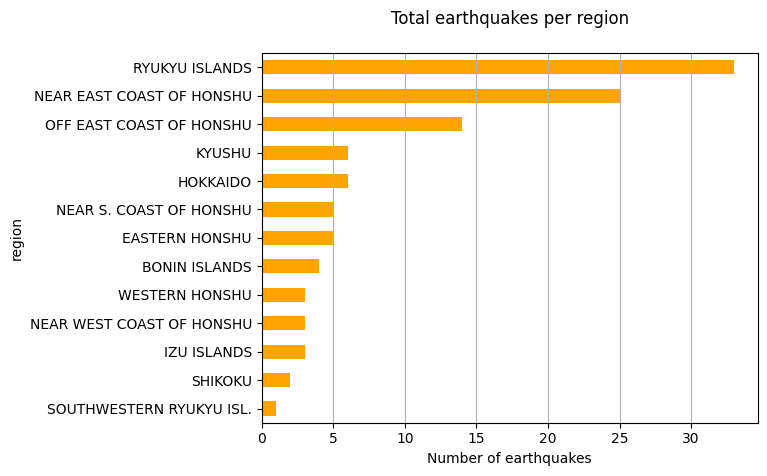

In [343]:
m = df.groupby("region").size().sort_values()
region_plot = m.plot(kind="barh", color="orange")
region_plot.set_xlabel("Number of earthquakes")
# m.set_ylabel("Region")
region_plot.set_title("Total earthquakes per region\n")
# region_plot.grid(True)
region_plot.grid(axis='x')

## Numpy Analysis

### Part1: Calculating Distance from Tokyo

#### Latitude & Longitude for Tokyo, Japan

In [344]:
tokyo_lat, tokyo_lng  = 35.6764, 139.6500

#### Distance calculations

In [345]:
# distance = np.sqrt(
# (df["latitude_deg"] - tokyo_lat)**2 +
# (df["longitude_deg"] - tokyo_lng)**2  
# ).round(2)

# df.insert(4, "Dist_from_TKY", value=distance)

# OR
lat_event = np.radians(df["latitude_deg"])
lng_event = np.radians(df["longitude_deg"])
lat_t = np.radians(tokyo_lat)
lng_t = np.radians(tokyo_lng)

dlat = lat_event - lat_t
dlng = lng_event - lng_t

a = np.sin(dlat / 2)**2 + np.cos(lat_event) * np.cos(lat_t) * np.sin(dlng / 2)**2
c = 2 * np.arcsin(np.sqrt(a))

# Radius of Earth in kilometers = 6371.00

distance = (c * 6371).round(2)
df.insert(4, "dist_to_Tokyo_km", value=distance)

### Part2: Earthquake Magnitude Analysis

#### Date Range for this Analysis

In [346]:

start_date = df.iloc[-1,0]
start_date = str(start_date).split()[0]
end_date = df.iloc[0,0]
end_date = str(end_date).split()[0]
print(f"From {start_date} to {end_date}")

From 2025-09-15 to 2025-10-12


#### Earthquake Magnitude Average

In [347]:
mag_average = np.mean(df["magnitude_value"])
print(f"Average magnitude for earthquakes from {start_date} to {end_date} was {mag_average:.2f}")

Average magnitude for earthquakes from 2025-09-15 to 2025-10-12 was 3.87


#### Earthquake Magnitude Variance & Standard Deviation

In [348]:
mag_std_dev = np.std(df["magnitude_value"])
mag_var = mag_std_dev ** 2
print(f"Variance of magnitude for earthquakes from {start_date} to {end_date} was {mag_var:.2f}")
print(f"Standard deviation of magnitude for earthquakes from {start_date} to {end_date} was {mag_std_dev:.2f}")

Variance of magnitude for earthquakes from 2025-09-15 to 2025-10-12 was 0.45
Standard deviation of magnitude for earthquakes from 2025-09-15 to 2025-10-12 was 0.67


#### Earthquake Magnitude Percentile

In [349]:
mag_p25 = np.percentile(df["magnitude_value"], 25)
mag_p50 = np.percentile(df["magnitude_value"], 50)
mag_p75 = np.percentile(df["magnitude_value"], 75)
print(f"From {start_date} to {end_date} magnitude for:")
print(f"25% of earthquakes was equal or less than {mag_p25:.2f}")
print(f"50% of earthquakes was equal or less than {mag_p50:.2f}")
print(f"75% of earthquakes was equal or less than {mag_p75:.2f}")

From 2025-09-15 to 2025-10-12 magnitude for:
25% of earthquakes was equal or less than 3.30
50% of earthquakes was equal or less than 3.80
75% of earthquakes was equal or less than 4.50


# Exporting cleaned data 

In [350]:
df.to_csv('JAPAN_EMSC_cleaned.csv' , encoding='utf-8-sig', index=False)